**This notebook focuses on the effectiveness of PixelDefend against adversarial attacks on the MNIST and MARVEL datasets.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

from keras_radam import RAdam

import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import PixelDefend
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier, PyTorchClassifier
from art.utils import load_mnist

### Load PixelCNN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, utils, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

#### Create PixelCNN classifier

*Define PixelCNN architecture*

In [3]:
class MaskedCNN(nn.Conv2d):
	"""
	Implementation of Masked CNN Class as explained in A Oord et. al. 
	Taken from https://github.com/jzbontar/pixelcnn-pytorch
	"""

	def __init__(self, mask_type, *args, **kwargs):
		self.mask_type = mask_type
		assert mask_type in ['A', 'B'], "Unknown Mask Type"
		super(MaskedCNN, self).__init__(*args, **kwargs)
		self.register_buffer('mask', self.weight.data.clone())

		_, depth, height, width = self.weight.size()
		self.mask.fill_(1)
		if mask_type =='A':
			self.mask[:,:,height//2,width//2:] = 0
			self.mask[:,:,height//2+1:,:] = 0
		else:
			self.mask[:,:,height//2,width//2+1:] = 0
			self.mask[:,:,height//2+1:,:] = 0


	def forward(self, x):
		self.weight.data*=self.mask
		return super(MaskedCNN, self).forward(x)

In [4]:
import torch.nn as nn

class PixelCNN(nn.Module):
	"""
	Network of PixelCNN as described in A Oord et. al. 
	"""
	def __init__(self, no_layers=8, kernel = 7, channels=64, device=None):
		super(PixelCNN, self).__init__()
		self.no_layers = no_layers
		self.kernel = kernel
		self.channels = channels
		self.layers = {}
		self.device = device

		self.Conv2d_1 = MaskedCNN('A',1,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_1 = nn.BatchNorm2d(channels)
		self.ReLU_1= nn.ReLU(True)

		self.Conv2d_2 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_2 = nn.BatchNorm2d(channels)
		self.ReLU_2= nn.ReLU(True)

		self.Conv2d_3 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_3 = nn.BatchNorm2d(channels)
		self.ReLU_3= nn.ReLU(True)

		self.Conv2d_4 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_4 = nn.BatchNorm2d(channels)
		self.ReLU_4= nn.ReLU(True)

		self.Conv2d_5 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_5 = nn.BatchNorm2d(channels)
		self.ReLU_5= nn.ReLU(True)

		self.Conv2d_6 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_6 = nn.BatchNorm2d(channels)
		self.ReLU_6= nn.ReLU(True)

		self.Conv2d_7 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_7 = nn.BatchNorm2d(channels)
		self.ReLU_7= nn.ReLU(True)

		self.Conv2d_8 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_8 = nn.BatchNorm2d(channels)
		self.ReLU_8= nn.ReLU(True)

		self.out = nn.Conv2d(channels, 256, 1)

	def forward(self, x):
		x = self.Conv2d_1(x)
		x = self.BatchNorm2d_1(x)
		x = self.ReLU_1(x)

		x = self.Conv2d_2(x)
		x = self.BatchNorm2d_2(x)
		x = self.ReLU_2(x)

		x = self.Conv2d_3(x)
		x = self.BatchNorm2d_3(x)
		x = self.ReLU_3(x)

		x = self.Conv2d_4(x)
		x = self.BatchNorm2d_4(x)
		x = self.ReLU_4(x)

		x = self.Conv2d_5(x)
		x = self.BatchNorm2d_5(x)
		x = self.ReLU_5(x)

		x = self.Conv2d_6(x)
		x = self.BatchNorm2d_6(x)
		x = self.ReLU_6(x)

		x = self.Conv2d_7(x)
		x = self.BatchNorm2d_7(x)
		x = self.ReLU_7(x)

		x = self.Conv2d_8(x)
		x = self.BatchNorm2d_8(x)
		x = self.ReLU_8(x)

		return self.out(x)


*Load MNIST pre-trained PixelCNN*

In [70]:
model = PixelCNN()
# model.load_state_dict(torch.load('/home/cyber/Desktop/Adrian/PixelCNN_Singh_Hrituraj/model.pt'))
# model.load_state_dict(torch.load('/home/cyber/miniconda3/envs/tf-gpu/PixelCNN-Pytorch-master/Models/Model_Checkpoint_Last.pt'))
# model.eval()

*Create PixelCNN classifier*

In [71]:
# model = PixelCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
pixelcnn = PyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(28, 28, 1), nb_classes=10, clip_values=(0, 1)
)

#### Test PixelDefend

In [72]:
%store -r x_test_JSMA_MNIST
x_test_adv = x_test_JSMA_MNIST

*Pre-process input for PixelDefend*

In [73]:
adv = np.transpose(x_test_adv, (0, -1, 1, 2))
print(x_test_adv.shape)
print(adv.shape)

(10000, 28, 28, 1)
(10000, 1, 28, 28)


*Transform input*

In [74]:
defence = PixelDefend(eps=5, pixel_cnn=pixelcnn, verbose=True)

In [75]:
# x_test_adv = x_test_adv.astype(np.float32)
x_test_adv_pd = defence(adv[0:10]*255)[0] / 255

PixelDefend:   0%|          | 0/10 [00:00<?, ?it/s]

*Post-process output for classification and plotting*

In [76]:
x_test_adv_pd = np.transpose(x_test_adv_pd, (0, 2, -1, 1))
print(x_test_adv_pd.shape)

(10, 28, 28, 1)


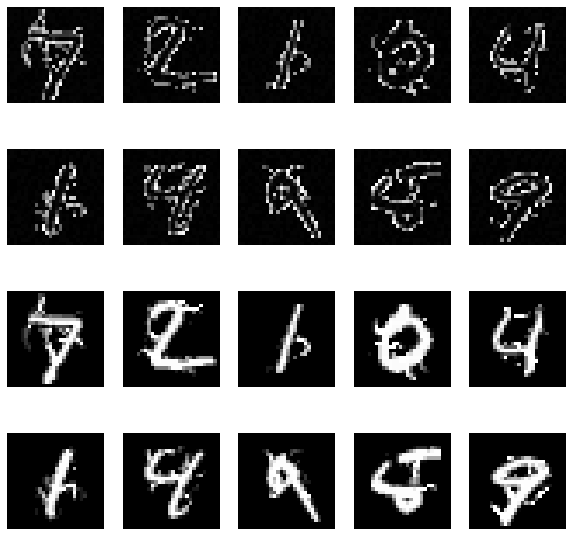

In [77]:
# Plot images
plt.figure(figsize=(10, 10))

for i in range(10):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(x_test_adv_pd[i], cmap='gray')
    plt.axis("off")
    
    ax = plt.subplot(4,5,i+11)
    plt.imshow(x_test_adv[i], cmap='gray')
    plt.axis("off")

### **Modification: Disabling eager execution to enable adversarial crafting**

In [ ]:
tf.compat.v1.disable_eager_execution()

### **Load MARVEL dataset**

In [ ]:
x_train = []
y_train = []
x_test_cln = []
y_test_cln = [] 
min_pixel_value = 0
max_pixel_value = 1

def marvel_class(filename):
    switcher={
        'HeavyLoadCarrier': [1,0,0,0,0,0,0,0,0],
        'CombatVessel': [0,1,0,0,0,0,0,0,0],
        'ContainerShip': [0,0,1,0,0,0,0,0,0],
        'PassengersShip': [0,0,0,1,0,0,0,0,0],
        'Ro-roCargo': [0,0,0,0,1,0,0,0,0],
        'Tanker': [0,0,0,0,0,1,0,0,0],
        'Tug': [0,0,0,0,0,0,1,0,0],
        'SupplyVessel': [0,0,0,0,0,0,0,1,0],
        'Yacht': [0,0,0,0,0,0,0,0,1]
    }
    return switcher.get(filename)

def load_training_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/train_9/"+filename
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_train_cln.append(img/255)
            y_train_cln.append(marvel_class(filename))
            i = i+1
        if i == 100:
            break
    return x_train_cln, y_train_cln

def load_test_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/test_9/"+filename
    i = 0
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_test_cln.append(img/255)
            y_test_cln.append(marvel_class(filename))
            i = i + 1
        if i == 100:
            break
    return x_test_cln, y_test_cln

# for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/train_9"):
#     load_training_data(filename)
#     print(filename)

for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/test_9"):
    load_test_data(filename)
    print(filename)
    
#load_training_data("/home/cyber/Desktop/Adrian/marvel_data/test_9/CombatVessel")


*Modification: Convert MARVEL x_test/x_train from uint8 into float32, to enable classification*

In [ ]:
x_test_cln = np.array(x_test_cln, dtype=np.float32)

### **Load MNIST dataset**

In [ ]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_mnist()
# x_test_cln, y_test_cln = x_test_cln[:1000], y_test_cln[:100]

### **Load / Create classifier model**

*Load MNIST pre-trained model*

In [ ]:
model = load_model("/home/cyber/mnist_trained_model.h5")

*Load MARVEL pre-trained model*

In [ ]:
model_path = "/home/cyber/Desktop/Adrian/Xception-10-0.74.hdf5"
model = load_model(model_path, custom_objects={'RAdam': RAdam}, compile=False)

*Optional step: Train and save a model for future use*

In [ ]:
# model.fit(x_train_cln, y_train_cln, batch_size=64, epochs=10, verbose=True)

In [ ]:
# model.save("/home/cyber/dataset_trained_model.h5")

*Create ART classifier*

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on the clean test set

In [ ]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on clean test examples: {}%".format(accuracy_cln * 100))

Step 2: Split the clean test set into its true and false positives

In [ ]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of clean true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of clean false positives: {:}'.format(len(x_test_cln_fp)))

Step 3: Craft adversarial examples

*Jacobian-based Saliency Map Attack (JSMA)*

In [ ]:
# adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_JSMA_MARVEL

*Basic Iterative Method (BMI)*

In [ ]:
# adv_crafter = BasicIterativeMethod(classifier, eps=0.1, eps_step=0.01, max_iter=30)
# x_test_BIM_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_BIM_MARVEL

*Projected Gradient Descent (PGD)*

In [ ]:
# adv_crafter = ProjectedGradientDescent(classifier, eps=0.1, eps_step=0.01, max_iter=30)
# x_test_PGD_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_PGD_MARVEL

*NewtonFool*

In [ ]:
# adv_crafter =  NewtonFool(classifier=classifier, eta=0.005, max_iter=25, verbose=True)
# x_test_Newton_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_Newton_MARVEL

*DeepFool*

In [ ]:
# adv_crafter = DeepFool(classifier=classifier, epsilon=1e-06/255, max_iter=50)
# x_test_Deep_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_Deep_MARVEL

*Load existing Adversarial Examples*

In [ ]:
%store -r x_test_JSMA_MNIST
x_test_adv = x_test_JSMA_MNIST

Step 4: Evaluate the classifier on the adversarial test set

In [ ]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Step 5: Split the adversarial test set into its true and false positives

In [ ]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Optional step: Plot clean examples and their adversarial counterparts

In [ ]:
# Plot images
plt.figure(figsize=(10, 10))
num = 3

for i in range(num):
    ax = plt.subplot(4, num, i + 1)
    plt.imshow(x_test_cln[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[i]))
    plt.axis("off")
    
    ax = plt.subplot(4, num, i + num + 1)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_adv,axis=1)[i]))
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## **Section 2 - Defence**

### **PixelDefend**

Step 1: Transform input

*Pre-process input for PixelDefend*

In [ ]:
x_test_cln_pre = np.transpose(x_test_cln, (0, -1, 1, 2))
x_test_cln_tp_pre = np.transpose(x_test_cln_tp, (0, -1, 1, 2))
x_test_cln_fp_pre = np.transpose(x_test_cln_fp, (0, -1, 1, 2))

In [ ]:
x_test_adv_pre = np.transpose(x_test_adv, (0, -1, 1, 2))
x_test_adv_tp_pre = np.transpose(x_test_adv_tp, (0, -1, 1, 2))
x_test_adv_fp_pre = np.transpose(x_test_adv_fp, (0, -1, 1, 2))

*Transform input*

In [ ]:
defence = PixelDefend(eps=16, pixel_cnn=pixelcnn, verbose=True)

In [ ]:
x_test_cln_pre_pd = defence(x_test_cln_pre * 255)[0] / 255
x_test_cln_tp_pre_pd = defence(x_test_cln_tp_pre * 255)[0] / 255
x_test_cln_fp_pre_pd = defence(x_test_cln_fp_pre * 255)[0] / 255

In [ ]:
x_test_adv_pre_pd = defence(x_test_adv_pre * 255)[0] / 255
x_test_adv_tp_pre_pd = defence(x_test_adv_tp_pre * 255)[0] / 255
x_test_adv_fp_pre_pd = defence(x_test_adv_fp_pre * 255)[0] / 255

*Post-processing output for classification and plotting*

In [ ]:
x_test_cln_pd = np.transpose(x_test_cln_pre_pd, (0, 2, -1, 1))
x_test_cln_tp_pd = np.transpose(x_test_cln_tp_pre_pd, (0, 2, -1, 1))
x_test_cln_fp_pd = np.transpose(x_test_cln_fp_pre_pd, (0, 2, -1, 1))

In [ ]:
x_test_adv_pd = np.transpose(x_test_adv_pre_pd, (0, 2, -1, 1))
x_test_adv_tp_pd = np.transpose(x_test_adv_tp_pre_pd, (0, 2, -1, 1))
x_test_adv_fp_pd = np.transpose(x_test_adv_fp_pre_pd, (0, 2, -1, 1))

Step 2: Evaluate the classifier on all 4 sets of data after PixelDefend

In [ ]:
predictions_cln_pd = classifier.predict(x_test_cln_pd)
accuracy_cln_pd = np.sum(np.argmax(predictions_cln_pd, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Effect of PixelDefend on entire clean test set: {:.2f}%".format((accuracy_cln_pd - accuracy_cln) * 100))
 
predictions_cln_tp_pd = classifier.predict(x_test_cln_tp_pd)
accuracy_cln_tp_pd = np.sum(np.argmax(predictions_cln_tp_pd, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on true positive clean test examples after PixelDefend: {:.2f}%".format(accuracy_cln_tp_pd * 100))
print("\nAccuracy drop on true positive clean test examples after PixelDefend: {:.2f}%".format((1 - accuracy_cln_tp_pd) * 100))

predictions_cln_fp_pd = classifier.predict(x_test_cln_fp_pd)
accuracy_cln_fp_pd = np.sum(np.argmax(predictions_cln_fp_pd, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on false positive clean test examples after PixelDefend: {:.2f}%".format(accuracy_cln_fp_pd * 100))

predictions_adv_pd = classifier.predict(x_test_adv_pd)
accuracy_adv_pd = np.sum(np.argmax(predictions_adv_pd, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("\nEffect of PixelDefend on entire adversarial test set: {:.2f}%".format((accuracy_adv_pd-accuracy_adv) * 100))

predictions_adv_tp_pd = classifier.predict(x_test_adv_tp_pd)
accuracy_adv_tp_pd = np.sum(np.argmax(predictions_adv_tp_pd, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on true positive adversarial test examples after PixelDefend: {:.2f}%".format(accuracy_adv_tp_pd * 100))
print("\nAccuracy drop on true positive adversarial test examples after PixelDefend: {:.2f}%".format((1 - accuracy_adv_tp_pd) * 100))

predictions_adv_fp_pd = classifier.predict(x_test_adv_fp_pd)
accuracy_adv_fp_pd = np.sum(np.argmax(predictions_adv_fp_pd, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on false positive adversarial test examples after PixelDefend: {:.2f}%".format(accuracy_adv_fp_pd * 100))

Step 3: Plot all data pre- and post-transformation

In [ ]:
# Plot images
predictions_cln_tp = classifier.predict(x_test_cln_tp)
predictions_cln_fp = classifier.predict(x_test_cln_fp)
predictions_adv_tp = classifier.predict(x_test_adv_tp)
predictions_adv_fp = classifier.predict(x_test_adv_fp)

plt.figure(figsize=(10, 10))

#Plot clean true positives
ax = plt.subplot(4, 2, 2*0+1)
plt.imshow(x_test_cln_tp[0], cmap='gray')
ax.set_title('Clean TP: {:}'.format(np.argmax(predictions_cln_tp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 2*0+2)
plt.imshow(x_test_cln_tp_pd[0], cmap='gray')
ax.set_title('Clean TP after PixelDefend: {:}'.format(np.argmax(predictions_cln_tp_pd,axis=1)[0]))
plt.axis("off")

#Plot clean false positives
ax = plt.subplot(4, 2, 2*1+1)
plt.imshow(x_test_cln_fp[0], cmap='gray')
ax.set_title('Clean FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp,axis=1)[0], np.argmax(y_test_cln_fp,axis=1)[0]), fontsize=20)
plt.axis("off")

ax = plt.subplot(4, 2, 2*1+2)
plt.imshow(x_test_cln_fp_pd[0], cmap='gray')
ax.set_title('Clean FP after PixelDefend: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp_pd,axis=1)[0], np.argmax(y_test_cln_fp,axis=1)[0]))
plt.axis("off")

#Plot adversarial true positives
ax = plt.subplot(4, 2, 2*2+1)
plt.imshow(x_test_adv_tp[0], cmap='gray')
ax.set_title('Adversarial TP: {:}'.format(np.argmax(predictions_adv_tp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 2*2+2)
plt.imshow(x_test_adv_tp_pd[0], cmap='gray')
ax.set_title('Adversarial TP after PixelDefend: {:}'.format(np.argmax(predictions_adv_tp_pd,axis=1)[0]))
plt.axis("off")

#Plot adversarial false positivies
ax = plt.subplot(4, 2, 2*3+1)
plt.imshow(x_test_adv_fp[0], cmap='gray')
ax.set_title('Adversarial FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp,axis=1)[0], np.argmax(y_test_adv_fp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 2*3+2)
plt.imshow(x_test_adv_fp_pd[0], cmap='gray')
ax.set_title('Adversarial FP after PixelDefend: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp_pd,axis=1)[0], np.argmax(y_test_adv_fp,axis=1)[0]))
plt.axis("off")
    
plt.tight_layout()
plt.show()

## Others

Optional step: Compare the performance of TotalVarMin against the adversary over a range of eps values

In [ ]:
# eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# accuracy_original = []
# accuracy_robust = []

# adv_crafter = FastGradientMethod(classifier)
# adv_crafter_robust = FastGradientMethod(robust_classifier)

# for eps in eps_range:
#     adv_crafter.set_params(**{'eps': eps})
#     adv_crafter_robust.set_params(**{'eps': eps})
#     x_test_adv = adv_crafter.generate(x_test[:100])
#     x_test_adv_robust = adv_crafter_robust.generate(x_test[:100])
    
#     predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
#     accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
#     predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
#     accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

# eps_range = eps_range

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
# ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

# legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
# #legend.get_frame().set_facecolor('#00FFCC')

# plt.xlabel('Attack strength (eps)')
# plt.ylabel('Accuracy (%)')
# plt.show()

## PixelCNN

### Attempt 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, utils, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

def causal_mask(width, height, starting_point):
    row_grid, col_grid = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    mask = np.logical_or(
        row_grid < starting_point[0],
        np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
    return mask

def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(width, height, starting_point=(width//2, height//2 + include_center - 1))

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        _, n_channels, width, height = self.weight.size()

        mask = conv_mask(width, height, include_center=mask_type=='B')
        self.register_buffer('mask', torch.from_numpy(mask).float())

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


In [ ]:
class PixelCNN(nn.Module):
    n_channels = 4
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels
    
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )
        self.fc = nn.Linear(28*28, 28*28*64)

    def forward(self, x):
        x = x.view(-1, 28*28)
        logit_output = self.fc(x)
        logit_output = logit_output.view(-1, 64, 1, 28, 28)

        return logit_output

### Attempt 2: PixelCNN by Jzbontar

In [ ]:
device = torch.device("cuda")

In [ ]:
print('torch.cuda.is_available():', torch.cuda.is_available())

In [ ]:
import os
import time
import sys

from torch import nn, optim, cuda, backends
from torch.utils import data
backends.cudnn.benchmark = True


class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

fm = 64
model = nn.Sequential(
    MaskedConv2d('A', 1,  fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    nn.Conv2d(fm, 256, 1))
model.eval()
model = model.to(device)

tr = data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
te = data.DataLoader(datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=False, num_workers=1, pin_memory=True)
sample = torch.Tensor(144, 1, 28, 28).cuda()
optimizer = optim.Adam(model.parameters())
# for epoch in range(5):
#     # train
#     err_tr = []
#     cuda.synchronize()
#     time_tr = time.time()
#     model.train(True)
#     for input, _ in tr:
#         input = Variable(input.cuda(non_blocking=True))
#         target = Variable((input.data[:,0] * 255).long())
#         loss = F.cross_entropy(model(input), target)
#         err_tr.append(loss.data.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     cuda.synchronize()
#     time_tr = time.time() - time_tr

#     # compute error on test set
#     err_te = []
#     cuda.synchronize()
#     time_te = time.time()
#     model.train(False)
#     for input, _ in te:
#         input = Variable(input.cuda(non_blocking=True), volatile=True)
#         target = Variable((input.data[:,0] * 255).long())
#         loss = F.cross_entropy(model(input), target)
#         err_te.append(loss.data.item())
#     cuda.synchronize()
#     time_te = time.time() - time_te

#     # sample
#     sample.fill_(0)
#     model.train(False)
#     for i in range(28):
#         for j in range(28):
#             out = model(Variable(sample, volatile=True))
#             probs = F.softmax(out[:, :, i, j]).data
#             sample[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.
#     utils.save_image(sample, 'sample_{:02d}.png'.format(epoch), nrow=12, padding=0)

#     print('epoch={}; nll_tr={:.7f}; nll_te={:.7f}; time_tr={:.1f}s; time_te={:.1f}s'.format(
#         epoch, np.mean(err_tr), np.mean(err_te), time_tr, time_te))

### Attempt 3: PixelCNN by Kamenbliznashki

In [ ]:
"""
PixelCNN implementation
References:
    1. van den Oord, Pixel Recurrent Neural Networks 2016a
    2. van den Oord, Conditional Image Generation with PixelCNN Decoders, 2016c
"""


import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

image_dims=(1,28,28), n_bits=4, n_channels=128, n_out_conv_channels=1024, kernel_size=5, n_res_layers=12, n_cond_classes=10


# --------------------
# Model components
# --------------------

def pixelcnn_gate(x):
    a, b = x.chunk(2,1)
    return torch.tanh(a) * torch.sigmoid(b)

class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type=None, mask_n_channels=None, gated=False, **kwargs):
        super().__init__(*args, **kwargs)
#         nn.init.constant_(bias, 0.)

        # set up mask -- cf PixelRNN paper Figure 2 Right: masks A and B
        mask_type = mask_type
        mask_n_channels = mask_n_channels
        center_row = kernel_size[0] // 2
        center_col = kernel_size[1] // 2

        mask = torch.ones_like(weight)         # shape (out_channels, in_channels, kernel_height, kernel_width)

        # mask out 1/ rows below the middle and 2/ center row pixels right of middle
        if center_row == 0:                         # case when kernel_size = (1,k) in horizontal stack
            mask[:, :, :, center_col+1:] = 0
        elif center_col == 0:                       # case when kernel_size = (k,1)
            mask[:, :, center_row+1:, :] = 0
        else:                                       # case when kernel_size = (k,k)
            mask[:, :, center_row+1:, :] = 0
            mask[:, :, center_row, center_col+1:] = 0

        # mask out center pixel in future channels -- mask A current channel is 0; mask B current channel is 1
        for i in range(mask_n_channels):
            for j in range(mask_n_channels):
                if (mask_type=='a' and i >= j) or (mask_type=='b' and i > j):
                    mask[j::mask_n_channels, i::mask_n_channels, center_row, center_col] = 0

        # mask out center row (vertical stack in a Gated Residual Layer); cf Conditional image generation with PixelCNN Decoders
        if mask_type == 'vstack':
            mask[:, :, center_row, :] = 0

        if gated:
            # pixelcnn gate splits the input in two along the channel dim;
            # ensure that both chunks receive the same mask by replicating the first half of the mask over the second
            mask = mask.chunk(2,0)[0].repeat(2,1,1,1)

        # final mask
        register_buffer('mask', mask)

    def forward(self, x):
        weight.data *= mask
        return super().forward(x)

    def __repr__(self):
        s = super().__repr__()
        return s[:-1] + ', mask_type={}, mask_n_channels={}'.format(mask_type, mask_n_channels) + s[-1]


class GatedResidualLayer(nn.Module):
    """ Figure 2 in Conditional image generation with PixelCNN Decoders """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, mask_n_channels, n_cond_classes, norm_layer):
        super().__init__()
        residual = (in_channels==out_channels)
        norm_layer = norm_layer

        v   = MaskedConv2d(in_channels, 2*out_channels, kernel_size, padding=kernel_size//2,
                                mask_type='vstack', mask_n_channels=mask_n_channels, gated=True)
        h   = MaskedConv2d(in_channels, 2*out_channels, (1, kernel_size), padding=(0, kernel_size//2),
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=True)
        v2h = MaskedConv2d(2*out_channels, 2*out_channels, kernel_size=1,
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=True)
        h2h = MaskedConv2d(out_channels, out_channels, kernel_size=1,
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=False)

        if n_cond_classes:
            proj_h = nn.Linear(n_cond_classes, 2*out_channels)

        if norm_layer:
            norm_layer_v = nn.BatchNorm2d(out_channels)
            norm_layer_h = nn.BatchNorm2d(out_channels)

    def forward(self, x_v, x_h, h=None):
        # projection of h if included for conditional generation (cf paper section 2.3 -- added before the pixelcnn_gate)
        proj_y = proj_h(h)[:,:,None,None] if h is not None else 0

        # vertical stack
        x_v_out = v(x_v)
        x_v2h = v2h(x_v_out) + proj_y
        x_v_out = pixelcnn_gate(x_v_out)

        # horizontal stack
        x_h_out = h(x_h) + x_v2h + proj_y
        x_h_out = pixelcnn_gate(x_h_out)
        x_h_out = h2h(x_h_out)

        # residual connection
        if residual:
            x_h_out = x_h_out + x_h

        # normalization
        if norm_layer:
            x_v_out = norm_layer_v(x_v_out)
            x_h_out = norm_layer_h(x_h_out)

        return x_v_out, x_h_out

    def extra_repr(self):
        return 'residual={}, norm_layer={}'.format(residual, norm_layer)


# --------------------
# PixelCNN
# --------------------

class PixelCNN(nn.Module):
    def __init__(self, image_dims, n_bits, n_channels, n_out_conv_channels, kernel_size, n_res_layers, n_cond_classes, norm_layer=True):
        super().__init__()
        C, H, W = image_dims

        input_conv = MaskedConv2d(C, 2*n_channels, kernel_size=7, padding=3, mask_type='a', mask_n_channels=C, gated=True)
        res_layers = nn.ModuleList([
            GatedResidualLayer(n_channels, n_channels, kernel_size, 'b', C, n_cond_classes, norm_layer)
            for _ in range(n_res_layers)])
        conv_out1 = MaskedConv2d(n_channels, 2*n_out_conv_channels, kernel_size=1, mask_type='b', mask_n_channels=C, gated=True)
        conv_out2 = MaskedConv2d(n_out_conv_channels, 2*n_out_conv_channels, kernel_size=1, mask_type='b', mask_n_channels=C, gated=True)
        output = MaskedConv2d(n_out_conv_channels, C * 2**n_bits, kernel_size=1, mask_type='b', mask_n_channels=C)

        if n_cond_classes:
            proj_h = nn.Linear(n_cond_classes, 2*n_channels)

    def forward(self, x, h=None):
        B, C, H, W = x.shape

        x = pixelcnn_gate(input_conv(x) + (proj_h(h)[:,:,None,None] if h is not None else 0.))
        x_v, x_h = x, x

        for l in res_layers:
            x_v, x_h = l(x_v, x_h)

        out = pixelcnn_gate(conv_out1(x_h))
        out = pixelcnn_gate(conv_out2(out))
        out = output(out)

        return out.reshape(B, -1, C, H, W)

In [ ]:
model = PixelCNN(image_dims=(1,28,28), n_bits=4, n_channels=128, n_out_conv_channels=1024, kernel_size=5, n_res_layers=12, n_cond_classes=10)
model.load_state_dict(torch.load('/home/cyber/miniconda3/envs/tf-gpu/pixel_models-master/results/pixelcnn/2021-05-04_08-44-00/checkpoint.pt'))

### Attempt 4: PixelCNN by Singh-Hrituraj

In [ ]:
class MaskedCNN(nn.Conv2d):
	"""
	Implementation of Masked CNN Class as explained in A Oord et. al. 
	Taken from https://github.com/jzbontar/pixelcnn-pytorch
	"""

	def __init__(self, mask_type, *args, **kwargs):
		self.mask_type = mask_type
		assert mask_type in ['A', 'B'], "Unknown Mask Type"
		super(MaskedCNN, self).__init__(*args, **kwargs)
		self.register_buffer('mask', self.weight.data.clone())

		_, depth, height, width = self.weight.size()
		self.mask.fill_(1)
		if mask_type =='A':
			self.mask[:,:,height//2,width//2:] = 0
			self.mask[:,:,height//2+1:,:] = 0
		else:
			self.mask[:,:,height//2,width//2+1:] = 0
			self.mask[:,:,height//2+1:,:] = 0


	def forward(self, x):
		self.weight.data*=self.mask
		return super(MaskedCNN, self).forward(x)

In [ ]:
import torch.nn as nn

class PixelCNN(nn.Module):
	"""
	Network of PixelCNN as described in A Oord et. al. 
	"""
	def __init__(self, no_layers=8, kernel = 7, channels=64, device=None):
		super(PixelCNN, self).__init__()
		self.no_layers = no_layers
		self.kernel = kernel
		self.channels = channels
		self.layers = {}
		self.device = device

		self.Conv2d_1 = MaskedCNN('A',1,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_1 = nn.BatchNorm2d(channels)
		self.ReLU_1= nn.ReLU(True)

		self.Conv2d_2 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_2 = nn.BatchNorm2d(channels)
		self.ReLU_2= nn.ReLU(True)

		self.Conv2d_3 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_3 = nn.BatchNorm2d(channels)
		self.ReLU_3= nn.ReLU(True)

		self.Conv2d_4 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_4 = nn.BatchNorm2d(channels)
		self.ReLU_4= nn.ReLU(True)

		self.Conv2d_5 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_5 = nn.BatchNorm2d(channels)
		self.ReLU_5= nn.ReLU(True)

		self.Conv2d_6 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_6 = nn.BatchNorm2d(channels)
		self.ReLU_6= nn.ReLU(True)

		self.Conv2d_7 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_7 = nn.BatchNorm2d(channels)
		self.ReLU_7= nn.ReLU(True)

		self.Conv2d_8 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_8 = nn.BatchNorm2d(channels)
		self.ReLU_8= nn.ReLU(True)

		self.out = nn.Conv2d(channels, 256, 1)

	def forward(self, x):
		x = self.Conv2d_1(x)
		x = self.BatchNorm2d_1(x)
		x = self.ReLU_1(x)

		x = self.Conv2d_2(x)
		x = self.BatchNorm2d_2(x)
		x = self.ReLU_2(x)

		x = self.Conv2d_3(x)
		x = self.BatchNorm2d_3(x)
		x = self.ReLU_3(x)

		x = self.Conv2d_4(x)
		x = self.BatchNorm2d_4(x)
		x = self.ReLU_4(x)

		x = self.Conv2d_5(x)
		x = self.BatchNorm2d_5(x)
		x = self.ReLU_5(x)

		x = self.Conv2d_6(x)
		x = self.BatchNorm2d_6(x)
		x = self.ReLU_6(x)

		x = self.Conv2d_7(x)
		x = self.BatchNorm2d_7(x)
		x = self.ReLU_7(x)

		x = self.Conv2d_8(x)
		x = self.BatchNorm2d_8(x)
		x = self.ReLU_8(x)

		return self.out(x)


In [ ]:
model = PixelCNN()
# model.load_state_dict(torch.load('/home/cyber/Desktop/Adrian/PixelCNN_Singh_Hrituraj/model.pt'))
# model.load_state_dict(torch.load('/home/cyber/miniconda3/envs/tf-gpu/PixelCNN-Pytorch-master/Models/Model_Checkpoint_Last.pt'))
# model.eval()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer.load_state_dict(torch.load('/home/cyber/Desktop/Adrian/PixelCNN_Singh_Hrituraj/optimizer.pt'))

### Attempt 5: PixelCNN by pclucas14

### Train PixelCNN

*Train PixelCNN*

In [ ]:
n_epochs = 1
batch_size_train = 128
batch_size_test = 1000
lr = 0.002
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root=r'/home/cyber/Desktop/Adrian', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [ ]:
train_losses = []
train_counter = []

In [ ]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(input=model(data), target=torch.squeeze(data).long())
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), '/home/cyber/Desktop/Adrian/PixelCNN_Singh_Hrituraj/model.pt')
      torch.save(optimizer.state_dict(), '/home/cyber/Desktop/Adrian/PixelCNN_Singh_Hrituraj/optimizer.pt')

In [ ]:
model = PixelCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

### Pre-process input for PixelDefend

In [ ]:
adv = torch.from_numpy(x_test_adv)
adv = adv.transpose(1,-1)
adv = adv.numpy()
# adv = adv.to('cuda')
print(x_test_adv.shape)
print(adv.shape)